# Is it a bird?
## Image Classifier
Reference: fast.ai Lecture 1 2022 edition

### Steps
1. Use DuckDuckGo to search for images of "bird photos"
1. Use DuckDuckGo to search for images of "forest photos"
1. Fine-tune a pretrained neural network to recognise these two groups
1. Try running this model on a picture of a bird and see if it works.

In [6]:
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastai.vision.all import *

## Proof of concept of image download with given search query

In [2]:
def search_images(phrase, max_images=20):
    print(f'Searching for {phrase}')
    return L(ddg_images(phrase, max_results=max_images)).itemgot('image')

In [3]:
urls = search_images('bird photos', max_images=1)
urls[0]

Searching for bird photos


'https://www.almanac.com/sites/default/files/image_nodes/bluebird-3456115_1920.jpg'

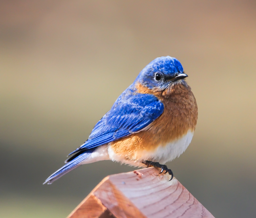

In [7]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=True)
img = Image.open(dest)

img.to_thumb(256,256)

Searching for forest photos


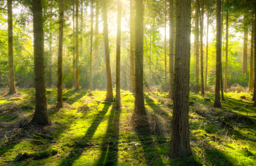

In [8]:
download_url(
    search_images('forest photos', max_images=1)[0],
    'forest.jpg', show_progress=True
)
Image.open('forest.jpg').to_thumb(256,256)

## Download the training data from proof-of-concept

In [9]:
searches = ['bird', 'forest']
path = Path('bird_or_not')
from time import sleep

for search in searches:
    dest = (path/search)
    dest.mkdir(exist_ok=True, parents=True)
    
    download_images(dest, urls=search_images(f'{search} photos'))
    sleep(10)
    
    download_images(dest, urls=search_images(f'{search} sun photos'))
    sleep(10)
    
    download_images(dest, urls=search_images(f'{search} shade photos'))
    sleep(10)
    
    resize_images(dest, max_size=400, dest=dest)
    

Searching for bird photos
Searching for bird sun photos
Searching for bird shade photos
Searching for forest photos
Searching for forest sun photos
Searching for forest shade photos


In [10]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

2

## Create dataloaders for train/valid data

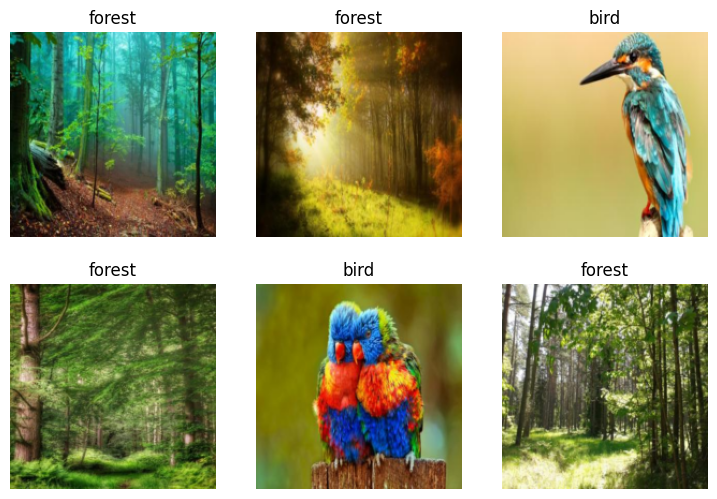

In [11]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')],    
).dataloaders(path, bs=16)

dls.show_batch(max_n=6)

## Fine tune the model

In [28]:
learner = vision_learner(dls, resnet34, metrics=error_rate)
learner.fine_tune(3)

/Users/neeraj/.virtualenvs/fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/neeraj/.virtualenvs/fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.118127,0.019634,0.000000,00:00


epoch,train_loss,valid_loss,error_rate,time
0,0.159718,0.028993,0.000000,00:01
1,0.124539,0.013420,0.000000,00:01
2,0.087763,0.020220,0.000000,00:01


This is a bird.
Probablity that this is a bird: 1.0000


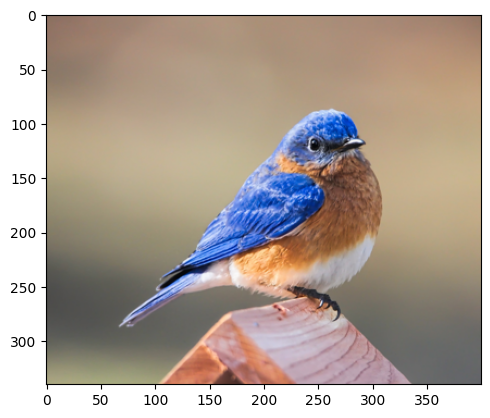

In [29]:
bird = PILImage.create('bird.jpg').to_thumb(400,400)
plt.imshow(bird)
is_bird,_, probs = learner.predict(bird)
print(f'This is a {is_bird}.')
print(f'Probablity that this is a bird: {probs[0]:.4f}')

This is a bird.
Probablity that this is a bird: 1.0000


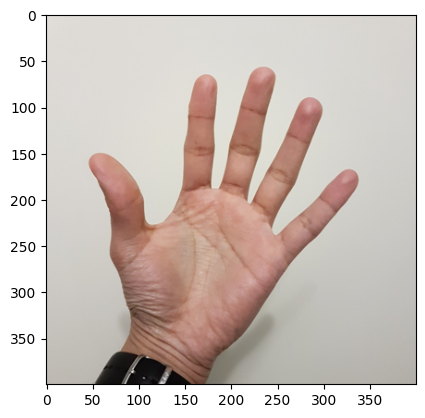

In [30]:
bird = PILImage.create('hand_five.jpg').to_thumb(400,400)
plt.imshow(bird)
is_bird,_, probs = learner.predict(bird)
print(f'This is a {is_bird}.')
print(f'Probablity that this is a bird: {probs[0]:.4f}')

This is a forest.
Probablity that this is a bird: 0.0000


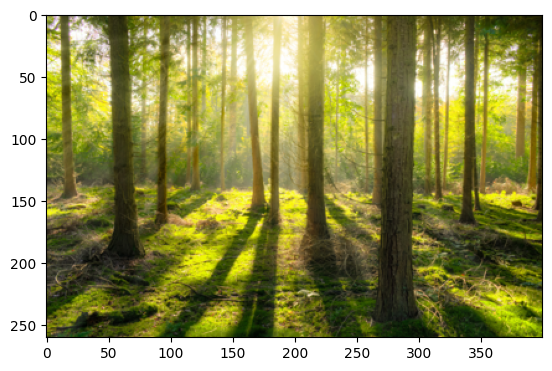

In [31]:
bird = PILImage.create('forest.jpg').to_thumb(400,400)
plt.imshow(bird)
is_bird,_, probs = learner.predict(bird)
print(f'This is a {is_bird}.')
print(f'Probablity that this is a bird: {probs[0]:.4f}')